Responsabilidades:
- Definir las especificaciones de desempeño: %OS y Ts.
- Calcular ζ y ωn, luego los polos dominantes deseados.
- Resolver las condiciones de fase y módulo para obtener Kp, Ti, Td, con ayuda simbólica o numérica.
- Ajustar si es necesario para cumplir condiciones.
<!--  -->
Entregables:
- Cálculos desarrollados (puede usar SymPy o MATLAB Symbolic Toolbox).
- Tabla con valores obtenidos y justificación
- Validación de que el punto cumple ∠L = -180° y |L| = 1


### Desarrollo
- Sobreimpulso (%OS): mide cuánto supera temporalmente la salida su valor final al aplicar una entrada escalón

Se calcula así: %OS = $\frac{Y_{max} - Y_{final}}{Y_{final}}$

**Para el Caso actual debera ser de 10%**

- Tiempo de asentamiento (Ts): es cuánto tarda la respuesta en mantenerse dentro de un rango pequeño

**Para el Caso actual debera ser 2 minutos**

### Encontrar $\zeta $ y $w_n$

La ecuación para encontrar $\zeta$ y $\omega_n$ es:

%OS $  \approx 100, e^{-\frac{\pi \zeta}{\sqrt{1-\zeta^2}}} $

$ T_s \approx \frac{4}{\zeta \omega_n}, \quad \omega_n = \text{frecuencia natural}. $


In [6]:
from sympy import symbols, Eq, exp, sqrt, pi, solve, N

zeta, wn, Ts, OS = symbols('zeta wn Ts OS', real=True, positive=True)

OS_value = 10  # 10%
Ts_value = 2   # 2 minutos

# Ecuación del sobreimpulso (OS ≈ 100 * exp(-pi*zeta / sqrt(1 - zeta**2)))
eq1 = Eq(OS, 100 * exp(-pi * zeta / sqrt(1 - zeta**2)))
# Ecuación del tiempo de asentamiento (Ts ≈ 4 / (zeta * wn))
eq2 = Eq(Ts, 4 / (zeta * wn))
# Sustituir valores numéricos
eq1_num = eq1.subs(OS, OS_value)
eq2_num = eq2.subs(Ts, Ts_value)

# Resolver la ecuación de OS para zeta
zeta_solutions = solve(eq1_num, zeta)
# Evaluar las soluciones numéricamente  
zeta_numeric = [N(sol) for sol in zeta_solutions if sol.is_real and sol > 0]
# Usar el valor numérico de zeta para encontrar wn
wn_val = solve(eq2_num.subs(zeta, zeta_numeric[0]), wn)[0]
zeta= zeta_numeric[0]
print("Valor de zeta:", zeta)
print("Valor de wn:", wn_val)

Valor de zeta: 0.591155033798898
Valor de wn: 3.38320725639016


$ s_{1,2} = -\zeta \omega_n \pm j \omega_n \sqrt{1 - \zeta^2} $  

In [9]:
s1 = symbols('s1', real=True, positive=True)
# Ecuación del polo dominante
first_pole = -zeta * wn_val + wn_val * sqrt(1 - zeta**2)*1j
print("Polo S1:", first_pole)
s2 = symbols('s2', real=True, positive=True)
# Ecuación del segundo polo
second_pole = -zeta * wn_val - wn_val * sqrt(1 - zeta**2)*1j
print("Polo S2:", second_pole)

Polo S1: -2.0 + 2.72875270768368*I
Polo S2: -2.0 - 2.72875270768368*I


### Condiciones de fase y modulo
- Fase

$\angle (T_i T_d s_d^2 + T_i s_d + 1) - \angle s_d - \angle (\tau s_d + 1) = -180^\circ - \angle K_p - \angle K.$

- Modulo

$K_p K \frac{\left| T_i T_d s_d^2 + T_i s_d + 1 \right|}{\left| T_i \right| \left| s_d \right| \left| \tau s_d + 1 \right|} = 1.$

In [2]:
import numpy as np
from scipy.optimize import minimize
from numpy import angle, abs, pi

# Parámetros de la planta
K = 0.3593
tau = 171.7428
s_d = -2.0 + 2.72875270768368j

# Ecuaciones a resolver
def condiciones(x):
    Kp, Ti, Td = x

    # Numerador del PID
    num = Ti * Td * s_d**2 + Ti * s_d + 1
    den = Ti * s_d * (tau * s_d + 1)

    # Fase: argumento total
    fase = angle(num) - angle(s_d) - angle(tau * s_d + 1)
    fase_error = (fase + pi) % (2*pi) - pi  # Normalizado entre [-pi, pi]

    # Módulo
    modulo = abs(num / den)
    modulo_total = Kp * K * modulo
    modulo_error = modulo_total - 1

    # Función objetivo: error cuadrático total
    return fase_error**2 + modulo_error**2

# Valores iniciales
x0 = [1.0, 100.0, 10.0]  # Kp, Ti, Td
bounds = [(0.001, 1000), (0.1, 1000), (0.001, 1000)]

# Minimización
resultado = minimize(condiciones, x0, bounds=bounds)

Kp_opt, Ti_opt, Td_opt = resultado.x

print(f"Kp = {Kp_opt:.4f}")
print(f"Ti = {Ti_opt:.4f}")
print(f"Td = {Td_opt:.4f}")


Kp = 24.4664
Ti = 99.9936
Td = 19.6913


### Evaluando Resultados

In [3]:
# Reutilar los resultados obtenidos
Kp_pre, Ti_opt, Td_opt = resultado.x

# Calculamos el valor actual de |L(sd)|
s_d = -2.0 + 2.72875270768368j

# Numerador y denominador del controlador PID
num = Ti_opt * Td_opt * s_d**2 + Ti_opt * s_d + 1
den = Ti_opt * s_d * (tau * s_d + 1)

# Magnitud actual
modulo_actual = abs(K * (num / den)) * Kp_pre

# Ajuste afín de Kp
Kp_ajustado = Kp_pre / modulo_actual

print(f"Magnitud actual |L(sd)| = {modulo_actual:.6f}")
print(f"Kp ajustado = {Kp_ajustado:.4f}")


Magnitud actual |L(sd)| = 1.000048
Kp ajustado = 24.4653


### Verificacion Grafica


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


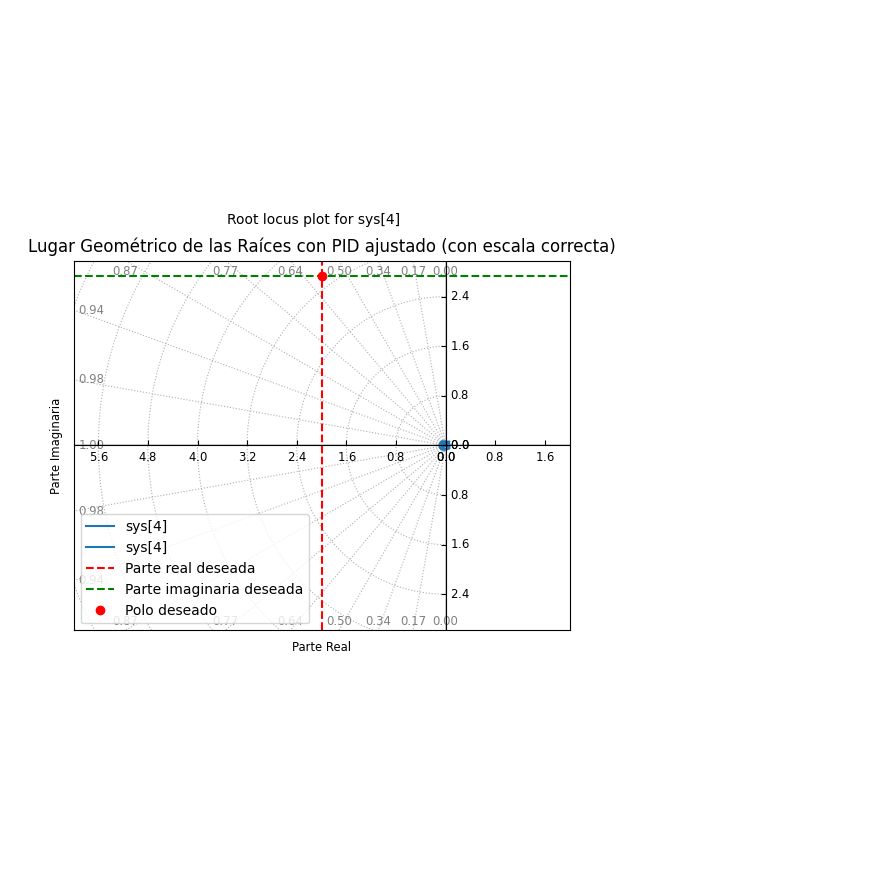

In [ ]:
import matplotlib.pyplot as plt
import control as ctrl

# Crear la función de transferencia del lazo abierto con PID ajustado
# PID: C(s) = Kp * (Td*Ti*s^2 + Ti*s + 1) / (Ti*s)
num_pid = [Kp_ajustado * Td_opt * Ti_opt, Kp_ajustado * Ti_opt, Kp_ajustado]
den_pid = [Ti_opt, 0]

# Planta: G(s) = K / (tau*s + 1), sin retardo (el LGR no soporta e^{-θs})
num_plant = [K]
den_plant = [tau, 1]

# Lazo abierto: L(s) = G(s) * C(s)
L = ctrl.TransferFunction(np.polymul(num_pid, num_plant),
                          np.polymul(den_pid, den_plant))

# Graficar LGR
plt.figure()
ctrl.root_locus(L)
plt.axvline(x=np.real(s_d), color='red', linestyle='--', label='Parte real deseada')
plt.axhline(y=np.imag(s_d), color='green', linestyle='--', label='Parte imaginaria deseada')
plt.plot(np.real(s_d), np.imag(s_d), 'ro', label='Polo deseado')

# Forzar límites del gráfico alrededor del punto deseado
plt.xlim(-6, 2)
plt.ylim(-5, 5)

plt.grid(True)
plt.legend()
plt.title("Lugar Geométrico de las Raíces con PID ajustado")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.show()

### Parametros PID finales

- **Kp** = 24.4653
- **Ti** = 99.9936
- **Td** = 19.6913